In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import math

n_labels = 10
cuda = torch.cuda.is_available()
device = "cuda:0" if cuda else "cpu"

def onehot(k):
    """
    Converts a number to its one-hot or 1-of-k representation
    vector.
    :param k: (int) length of vector
    :return: onehot function
    """
    def encode(label):
        y = torch.zeros(k)
        if label < k:
            y[label] = 1
        return y
    return encode

def log_standard_gaussian(x):
    """
    Evaluates the log pdf of a standard normal distribution at x.

    :param x: point to evaluate
    :return: log N(x|0,I)
    """
    return torch.sum(-0.5 * math.log(2 * math.pi) - x ** 2 / 2, dim=-1)


def log_gaussian(x, mu, log_var):
    """
    Returns the log pdf of a normal distribution parametrised
    by mu and log_var evaluated at x.

    :param x: point to evaluate
    :param mu: mean of distribution
    :param log_var: log variance of distribution
    :return: log N(x|µ,σ)
    """
    log_pdf = - 0.5 * math.log(2 * math.pi) - log_var / 2 - (x - mu)**2 / (2 * torch.exp(log_var))
    return torch.sum(log_pdf, dim=-1)

def get_mnist(location="./", batch_size=64, labels_per_class=100):
    from functools import reduce
    from operator import __or__
    from torch.utils.data.sampler import SubsetRandomSampler
    from torchvision.datasets import MNIST
    import torchvision.transforms as transforms

    flatten_bernoulli = lambda x: transforms.ToTensor()(x).view(-1).bernoulli()

    mnist_train = MNIST(location, train=True, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))
    mnist_valid = MNIST(location, train=False, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))

    def get_sampler(labels, n=None):
        # Only choose digits in n_labels
        (indices,) = np.where(reduce(__or__, [labels == i for i in np.arange(n_labels)]))

        # Ensure uniform distribution of labels
        np.random.shuffle(indices)
        indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in range(n_labels)])

        indices = torch.from_numpy(indices)
        sampler = SubsetRandomSampler(indices)
        return sampler

    # Dataloaders for MNIST
    labelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,# num_workers=2, pin_memory=cuda,
                                           sampler=get_sampler(mnist_train.train_labels.numpy(), labels_per_class))
    unlabelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,# num_workers=2, pin_memory=cuda,
                                             sampler=get_sampler(mnist_train.train_labels.numpy()))
    validation = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, #num_workers=2, pin_memory=cuda,
                                             sampler=get_sampler(mnist_valid.test_labels.numpy()))

    return labelled, unlabelled, validation

class Perceptron(nn.Module):
    def __init__(self, dims, activation_fn=F.relu, output_activation=None):
        super(Perceptron, self).__init__()
        self.dims = dims
        self.activation_fn = activation_fn
        self.output_activation = output_activation

        self.layers = nn.ModuleList(list(map(lambda d: nn.Linear(*d), list(zip(dims, dims[1:])))))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i == len(self.layers)-1 and self.output_activation is not None:
                x = self.output_activation(x)
            else:
                x = self.activation_fn(x)

        return x
    
class Stochastic(nn.Module):
    """
    Base stochastic layer that uses the
    reparametrization trick [Kingma 2013]
    to draw a sample from a distribution
    parametrised by mu and log_var.
    """
    def reparametrize(self, mu, log_var):
        epsilon = Variable(torch.randn(mu.size()), requires_grad=False)

        if mu.is_cuda:
            epsilon = epsilon.cuda()

        # log_std = 0.5 * log_var
        # std = exp(log_std)
        std = log_var.mul(0.5).exp_()

        # z = std * epsilon + mu
        z = mu.addcmul(std, epsilon)

        return z
    
class GaussianSample(Stochastic):
    """
    Layer that represents a sample from a
    Gaussian distribution.
    """
    def __init__(self, in_features, out_features):
        super(GaussianSample, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.mu = nn.Linear(in_features, out_features)
        self.log_var = nn.Linear(in_features, out_features)

    def forward(self, x):
        mu = self.mu(x)
        log_var = F.softplus(self.log_var(x))

        return self.reparametrize(mu, log_var), mu, log_var


class GumbelSoftmax(Stochastic):
    """
    Layer that represents a sample from a categorical
    distribution. Enables sampling and stochastic
    backpropagation using the Gumbel-Softmax trick.
    """
    def __init__(self, in_features, out_features, n_distributions):
        super(GumbelSoftmax, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_distributions = n_distributions

        self.logits = nn.Linear(in_features, n_distributions*out_features)
        self.categories = nn.Linear(n_distributions*out_features, out_features)

    def forward(self, x, tau=1.0):
        logits = self.logits(x).view(-1, self.n_distributions)

        # variational distribution over categories
        softmax = F.softmax(logits, dim=-1) #q_y
        sample = self.reparametrize(logits, tau).view(-1, self.n_distributions,self.out_features)
#         sample = F.softmax(self.categories(sample),dim=-1)
        sample = torch.mean(sample, dim=1)
        return sample, softmax

    def reparametrize(self, logits, tau=1.0):
        epsilon = Variable(torch.rand(logits.size()), requires_grad=False).to(device)

        # Gumbel distributed noise
        gumbel = -torch.log(-torch.log(epsilon+1e-8)+1e-8)
        # Softmax as a continuous approximation of argmax
        y = F.softmax((logits + gumbel)/tau, dim=1)
        return y
    
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def __init__(self, size, dim=-1):
        super().__init__()
        self.dim = dim
        self.size = size
    def forward(self, input):
        return input.view(input.size(0), self.dim, self.size, self.size)


class GumbelAutoencoder(nn.Module):
    def __init__(self, dims, n_samples=100, cdim=1):
        super(GumbelAutoencoder, self).__init__()

        [x_dim, z_dim, h_dim] = dims
        self.z_dim = z_dim
        self.n_samples = n_samples
        self.cdim = cdim

        """self.encoder = nn.Sequential(
            UnFlatten(size=28),
            nn.Conv2d(1, 2, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.Conv2d(2, 2, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.Conv2d(2, 2, kernel_size=2, stride=1),
            nn.ReLU(),
            #nn.Conv2d(128, 256, kernel_size=4, stride=2),
            #nn.ReLU(),
            Flatten()
        )"""
        self.encoder = Perceptron([x_dim, *h_dim])
        self.dsampler = GumbelSoftmax(h_dim[-1], z_dim, n_samples)
        self.csampler = GaussianSample(h_dim[-1], cdim)
        self.decoder = Perceptron([z_dim + cdim, *reversed(h_dim), x_dim], output_activation=torch.sigmoid)
        """self.decoder = nn.Sequential(
            nn.Linear(z_dim + cdim, 1058),
            UnFlatten(dim=2, size=23),
            nn.ConvTranspose2d(2, 2, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2, 2, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2, 1, kernel_size=4, stride=1),
            #nn.ReLU(),
            #nn.ConvTranspose2d(32, 1, kernel_size=6, stride=2),
            nn.Sigmoid(),
            Flatten()
        )"""

        self.kl_divergence = 0

        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def _kld(self, qz):
        k = Variable(torch.FloatTensor([self.z_dim]), requires_grad=False).to(device)
        kl = qz * (torch.log(qz + 1e-8) - torch.log(1.0/k))
        kl = kl.view(-1, self.n_samples, self.z_dim)
        return torch.sum(torch.sum(kl, dim=1), dim=1)
    
    def _klc(self, z, q_param, p_param=None):
        """
        Computes the KL-divergence of
        some element z.

        KL(q||p) = -∫ q(z) log [ p(z) / q(z) ]
                 = -E[log p(z) - log q(z)]

        :param z: sample from q-distribuion
        :param q_param: (mu, log_var) of the q-distribution
        :param p_param: (mu, log_var) of the p-distribution
        :return: KL(q||p)
        """
        (mu, log_var) = q_param

        qz = log_gaussian(z, mu, log_var)

        if p_param is None:
            pz = log_standard_gaussian(z)
        else:
            (mu, log_var) = p_param
            pz = log_gaussian(z, mu, log_var)

        kl = qz - pz

        return kl

    def forward(self, x, y=None, tau=1, alpha=1):
        x = self.encoder(x)
        sample, qz = self.dsampler(x, tau)
        z, z_mu, z_log_var = self.csampler(x)

        self.kl_divergence =  self._kld(qz) +  self._klc(z, (z_mu, z_log_var))

        x_mu = self.decoder(torch.cat((sample, z), dim=1))

        return x_mu, sample

    def sample(self, z):
        return self.decoder(z)

In [2]:
# Latent space dimension should be equal to the number of classes=10
c_dim = 20

model = GumbelAutoencoder([784, 10, [256, 128]], n_samples=10, cdim=c_dim).to(device)
model

GumbelAutoencoder(
  (encoder): Perceptron(
    (layers): ModuleList(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=128, bias=True)
    )
  )
  (dsampler): GumbelSoftmax(
    (logits): Linear(in_features=128, out_features=100, bias=True)
    (categories): Linear(in_features=100, out_features=10, bias=True)
  )
  (csampler): GaussianSample(
    (mu): Linear(in_features=128, out_features=20, bias=True)
    (log_var): Linear(in_features=128, out_features=20, bias=True)
  )
  (decoder): Perceptron(
    (layers): ModuleList(
      (0): Linear(in_features=30, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=784, bias=True)
    )
  )
)

In [3]:
train_labelled, train, validation = get_mnist(location="./", batch_size=64)

# We use this custom BCE function until PyTorch implements reduce=False
def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999), weight_decay=1e-3)

In [4]:
from torch.autograd import Variable

# Temperature
tau = Variable(torch.FloatTensor([2]), requires_grad=False).to(device)
alpha = Variable(torch.FloatTensor([1]), requires_grad=False).to(device)

for epoch in range(50):
    model.train()
    total_loss = 0
    
    for (x, y) in train_labelled:
        x = Variable(x).to(device)
        y = Variable(y).to(device)
#         print(y)


        reconstruction, discrete_latents = model(x, tau=tau)
        
        likelihood = -binary_cross_entropy(reconstruction, x)
#         print(likelihood)
#         elbo = likelihood - model.kl_divergence - torch.norm(discrete_latents - y, 2)
        elbo = likelihood - model.kl_divergence + torch.sum(torch.log(torch.sum(discrete_latents.mul(y),-1)))
#         print(discrete_latents)
        L = -torch.mean(elbo)

        L.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += L.data.item()
    
    for (u, _) in train:
        u = Variable(u)

        if cuda: u = u.cuda(device=0)

        reconstruction, _ = model(u, tau=tau)
        
        likelihood = -binary_cross_entropy(reconstruction, u)
#         print(likelihood)
        elbo = likelihood - model.kl_divergence
        
        L = -torch.mean(elbo)

        L.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += L.data.item()
        
    
        
    m = len(train)
        
    #if epoch % 5 == 0:
    print(f"Epoch: {epoch}\tL: {total_loss/m:.2f}\tTau: {tau.item()}")

    # Anneal temperature variable
    
    tau = torch.max(tau * 0.9, torch.FloatTensor([0.5]).cuda())
    alpha = torch.max(alpha * 0.9, torch.FloatTensor([0.2]).cuda())
    
    

Epoch: 0	L: 198.46	Tau: 2.0
Epoch: 1	L: 160.77	Tau: 1.7999999523162842
Epoch: 2	L: 153.32	Tau: 1.619999885559082
Epoch: 3	L: 149.32	Tau: 1.4579998254776
Epoch: 4	L: 146.75	Tau: 1.3121998310089111
Epoch: 5	L: 145.03	Tau: 1.18097984790802
Epoch: 6	L: 143.70	Tau: 1.0628818273544312
Epoch: 7	L: 142.47	Tau: 0.9565936326980591
Epoch: 8	L: 141.59	Tau: 0.8609342575073242
Epoch: 9	L: 140.74	Tau: 0.7748408317565918
Epoch: 10	L: 140.16	Tau: 0.6973567008972168
Epoch: 11	L: 139.57	Tau: 0.6276209950447083
Epoch: 12	L: 139.03	Tau: 0.5648588538169861
Epoch: 13	L: 138.69	Tau: 0.508372962474823
Epoch: 14	L: 138.13	Tau: 0.5
Epoch: 15	L: 137.84	Tau: 0.5
Epoch: 16	L: 137.48	Tau: 0.5
Epoch: 17	L: 137.22	Tau: 0.5
Epoch: 18	L: 136.62	Tau: 0.5
Epoch: 19	L: 136.41	Tau: 0.5
Epoch: 20	L: 136.00	Tau: 0.5
Epoch: 21	L: 135.75	Tau: 0.5
Epoch: 22	L: 135.44	Tau: 0.5
Epoch: 23	L: 135.15	Tau: 0.5
Epoch: 24	L: 134.99	Tau: 0.5
Epoch: 25	L: 134.44	Tau: 0.5
Epoch: 26	L: 134.21	Tau: 0.5
Epoch: 27	L: 133.77	Tau: 0.5
Epoch: 28	

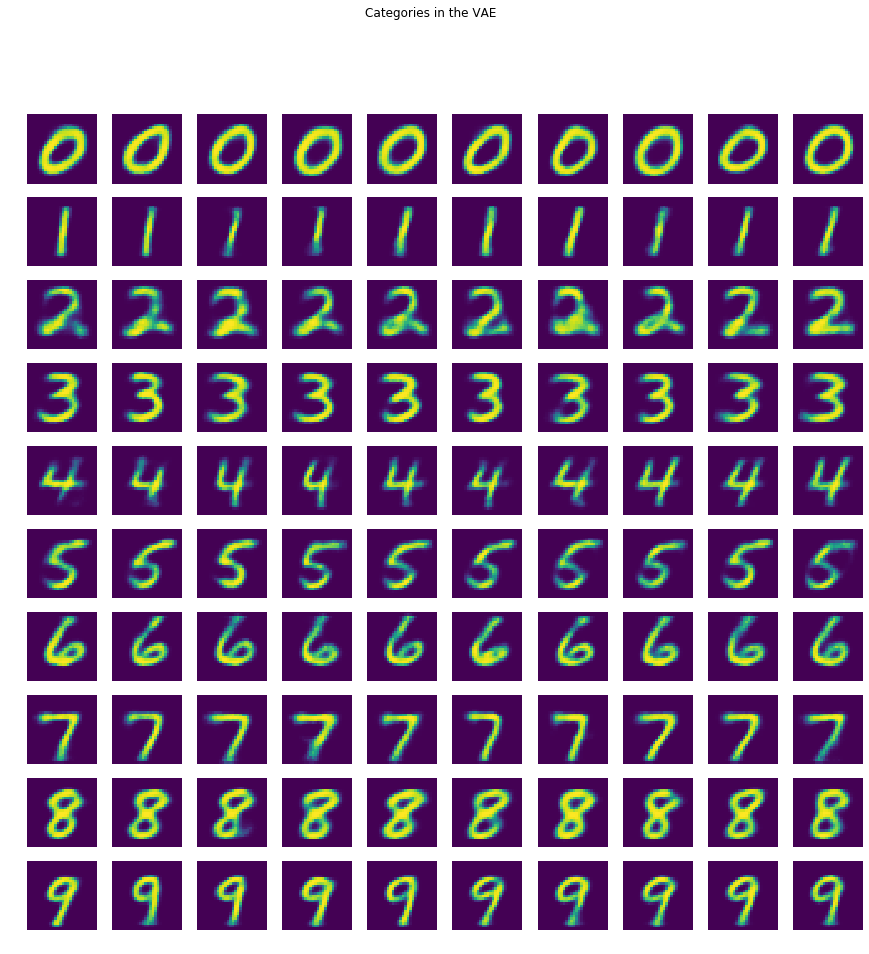

In [7]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(10, 10, figsize=(15, 15))

x = torch.zeros(100, c_dim+10).to(device)
for i in range(10):
    for j in range(10):
        x[i*10+j, i] = 1
        x[i*10+j, 10:c_dim+10] = torch.tensor(np.random.normal(size=c_dim))

reconstruction = model.decoder(x)
r = reconstruction.data.cpu().numpy()

for i, ax in enumerate(axarr.flat):
    ax.imshow(r[i].reshape(28, 28), cmap="viridis")
    ax.axis("off")
    
plt.suptitle("Categories in the VAE")
plt.show()

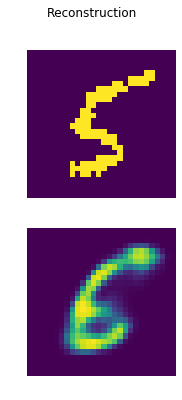

In [49]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(2, 1, figsize=(10, 6))

batch = next(iter(validation))[0][0].to(device)
reconstruction,_ = model(batch.view(1,784))
r = reconstruction.data.cpu().numpy()
comparison = [batch, r]
for i, ax in enumerate(axarr.flat):
    ax.imshow(comparison[i].reshape(28, 28), cmap="viridis")
    ax.axis("off")
    
plt.suptitle("Reconstruction")
plt.show()